# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import matplotlib
from scipy.interpolate import griddata
# Disable scientific notation
np.set_printoptions(suppress=True)

# Read Image

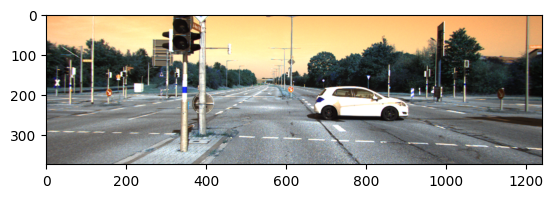

In [4]:
image = cv2.imread('L.png')
#image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)
width, height = image.shape[1], image.shape[0]

# Load Matrices

In [7]:
def load_matrices(intrinsic_matrix_path, extrinsic_matrix_path):
    '''
    Input - velo_2_cam, cam_2_cam
    Output - rotation_matrix, translation_matrix, intrinsic_matrix, extrinsic_matrix, rectification_matrix, projection_matrix
    
    '''
    velo_2_cam = open(extrinsic_matrix_path, "r")
    cam_2_cam = open(intrinsic_matrix_path,'r')

    lines = velo_2_cam.readlines()
    lines2 = cam_2_cam.readlines()

    rotation_matrix = np.array(lines[1][3:-1].split(),dtype=np.float32).reshape(3,3)
    translation_matrix = np.array(lines[2][3:-1].split(),dtype=np.float32).reshape(3,1)

    intrinsic_matrix = np.array(lines2[19][5:-1].split(),dtype = np.float32).reshape(3,3)
    extrinsic_matrix = np.hstack((rotation_matrix, translation_matrix))
    rectification_matrix = np.array(lines2[24][11:-1].split(),dtype = np.float32).reshape(3,3)
    projection_matrix = np.array(lines2[25][11:-1].split(),dtype = np.float32).reshape(-1,4)

    return rotation_matrix, translation_matrix, intrinsic_matrix, extrinsic_matrix, rectification_matrix, projection_matrix


In [8]:
rotation_matrix, translation_matrix, intrinsic_matrix, extrinsic_matrix, rectification_matrix, projection_matrix = load_matrices( 'calib_cam_to_cam.txt', "calib_velo_to_cam.txt")

In [3]:
velo_2_cam = open("calib_velo_to_cam.txt", "r")
cam_2_cam = open('calib_cam_to_cam.txt','r')

lines = velo_2_cam.readlines()
lines2 = cam_2_cam.readlines()

data_r = np.array(lines[1][3:-1].split(),dtype=np.float32).reshape(3,3)
data_t = np.array(lines[2][3:-1].split(),dtype=np.float32).reshape(3,1)

intrinsic_matrix = np.array(lines2[19][5:-1].split(),dtype = np.float32).reshape(3,3)
extrinsic_matrix = np.hstack((data_r, data_t))
rectification_matrix = np.array(lines2[24][11:-1].split(),dtype = np.float32).reshape(3,3)
projection_matrix = np.array(lines2[25][11:-1].split(),dtype = np.float32).reshape(-1,4)


# Create dataframe of lidar points 

In [9]:
def create_points_data(lidar_points_file) :

    '''
    Input -  Path to velodyne points as .bin file extension
    Output - Pandas DataFrame of the points with columns - X, Y, Z and I

    '''
    
    raw_pts = np.fromfile(lidar_points_file, dtype=np.float32).reshape(-1,4)
    points = pd.DataFrame(raw_pts,columns=['X','Y','Z','I'])
    points = points[points['X'] > 0]

    return points


In [11]:
points = create_points_data('V.bin')
points

,X,Y,Z,I
0,32.835999,0.056000,1.319,0.29
1,32.591999,0.107000,1.311,0.29
2,32.404999,0.208000,1.305,0.00
3,60.087002,1.163000,2.241,0.00
4,76.805000,20.544001,2.898,0.00
...,...,...,...,...
116679,3.713000,-1.438000,-1.741,0.00
116680,3.709000,-1.423000,-1.737,0.00
116681,3.707000,-1.409000,-1.733,0.00
116682,3.725000,-1.402000,-1.740,0.00


In [4]:
raw_pts = np.fromfile('V.bin', dtype=np.float32).reshape(-1,4)
points = pd.DataFrame(raw_pts,columns=['X','Y','Z','I'])
points = points[points['X'] > 0]

# Apply fusion algorithm

In [ ]:
def fuse_lidar_camera_data(image, lidar_points, R, T, rect_matrix, projection_matrix ):
    
    '''
    Input - Image, Velodyne Points, Rotation Matrix, Translation Vectors, Rectification Matrix and Projection Matrix

    Output - Image with Lidar points fused on the pixels.
    '''
    
    image = cv2.imread('L.png')
    
    pixel_points = []
    lidar_points = []
    
    for i in range(len(points)):
        x, y, z = points.iloc[i,:3]
        depth = math.sqrt(x**2 + y**2 + z**2)

        if 0 < depth < 25 :
            color = (255,0,0)
        elif 25 <= depth <= 50 :
            color = (0,255,0) 
        else :
            color = (0,0,255)

        world_pt = np.array([x,y,z]).T 
        pt_cam_coordinate = np.dot(rotation_matrix, world_pt) + translation_matrix.T.flatten()
        rectified_pt = np.dot(rectification_matrix,pt_cam_coordinate)
        rectified_pt = np.hstack((rectified_pt, [1]))
        projected_pt = np.dot(projection_matrix, rectified_pt)
        u , v  = int(projected_pt[0] / projected_pt[2]), int(projected_pt[1] / projected_pt[2])
        depth = float(projected_pt[2])
        if 0 < u < 1226 :
            if 0 < v < 370 :
                pixel_points.append((u,v))
                lidar_points.append((u,v,int(depth)))
                cv2.circle(image,(u,v),1,color)
    return image
    

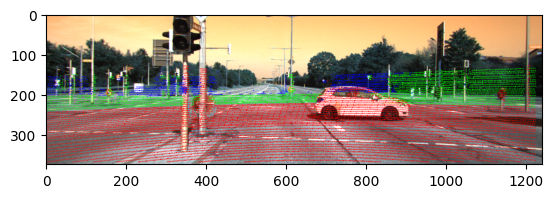

In [17]:
fused_image = fuse_lidar_camera_data(image, points, rotation_matrix, translation_matrix, rectification_matrix, projection_matrix)
plt.imshow(fused_image)

In [12]:
image = cv2.imread('L.png')
#print(image.shape)
pixel_points = []
lidar_points = []
lidar_points_comparison = []
for i in range(len(points)):
    x, y, z = points.iloc[i,:3]
    depth = math.sqrt(x**2 + y**2 + z**2)
    if 0 < depth < 25 :
        color = (255,0,0)
    elif 25 <= depth <= 50 :
        color = (0,255,0) 
    else :
        color = (0,0,255)
    world_pt = np.array([x,y,z]).T 
    pt_cam_coordinate = np.dot(data_r, world_pt) + data_t.T.flatten()
 
    rectified_pt = np.dot(rectification_matrix,pt_cam_coordinate)
    depth = round(float(rectified_pt[2]),2)
    rectified_pt = np.hstack((rectified_pt, [1]))
    projected_pt = np.dot(projection_matrix, rectified_pt)
    #print(projected_pt)
    u , v  = int(projected_pt[0] / projected_pt[2]), int(projected_pt[1] / projected_pt[2])
    if 0 < u < 1226 :
        if 0 < v < 370 :
            #print(depth, projected_pt[2])
            #break
            pixel_points.append((u,v))
            lidar_points.append((u,v,int(depth)))
            lidar_points_comparison.append((u,v,depth))

            cv2.circle(image,(u,v),1,color)
    


True

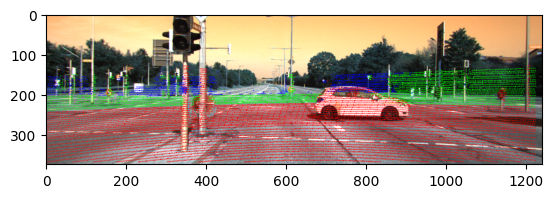

In [13]:
plt.imshow(image)
cv2.imwrite('Fused.png',image)

In [7]:
lidar_points_np = [(v,u,depth) for (u,v,depth) in lidar_points ]
sparse_depth_map = np.zeros(shape = (height,width))
for i,u,depth in lidar_points_np:
    sparse_depth_map[i,u] = depth

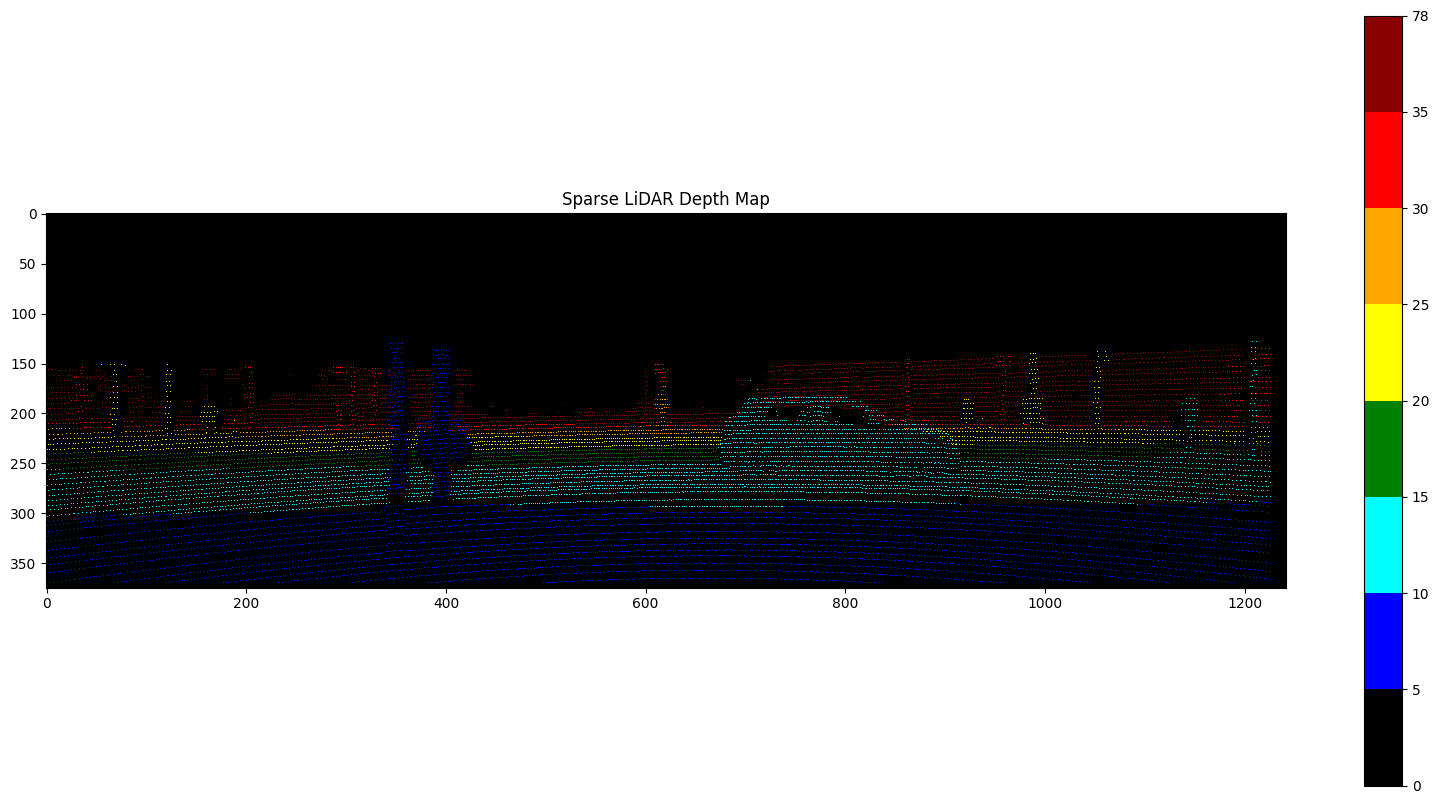

In [8]:
valid_depths = sparse_depth_map[sparse_depth_map > 0]
min_depth , max_depth = valid_depths.min(), valid_depths.max()
bins = [0, 5, 10, 15, 20, 25, 30, 35, np.max(sparse_depth_map)]  # Adjust as needed
colors = ["black", "blue", 'cyan', "green", "yellow", "orange", "red", "darkred"]  # Custom colors

# Create a colormap from the defined colors
cmap = matplotlib.colors.ListedColormap(colors)

# Use BoundaryNorm to ensure bins match colors, but no normalization is applied
norm = matplotlib.colors.BoundaryNorm(bins, cmap.N)
plt.figure(figsize=(20,10))
plt.imshow(sparse_depth_map, cmap=cmap, norm=norm, interpolation='nearest')
plt.title("Sparse LiDAR Depth Map")
plt.colorbar()
plt.savefig('Sparse Point Clouds.png')
plt.show()

#

# Nearest Neighbour Interpolation

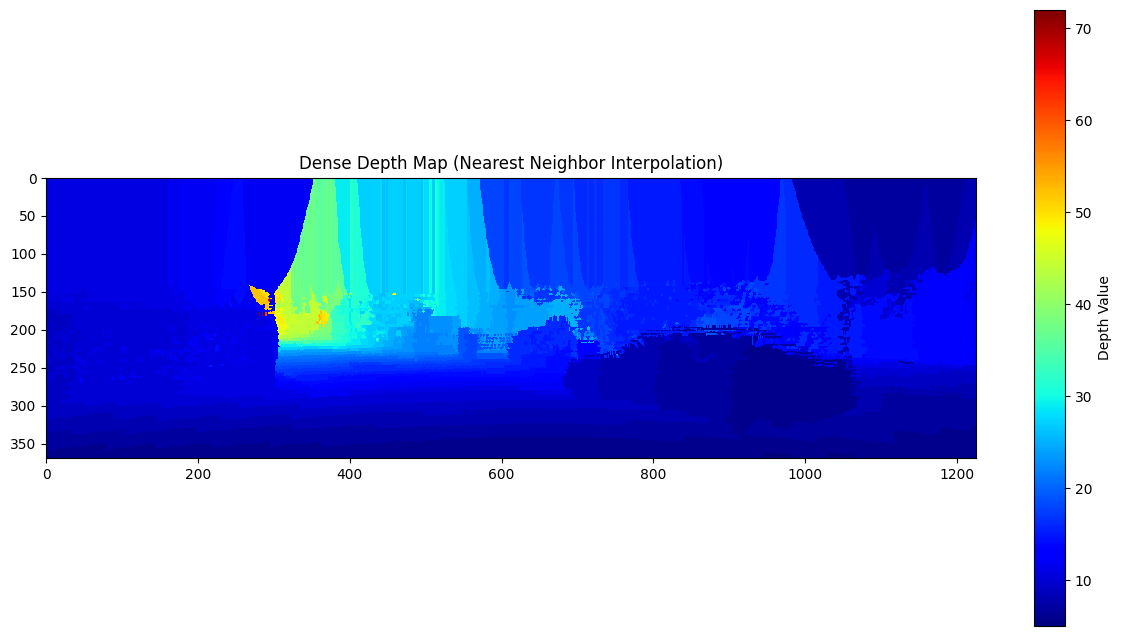

In [89]:
valid_pixels = sparse_depth_map > 0
u_coords, v_coords = np.where(valid_pixels)  # Get coordinates of valid depth values
depth_values = sparse_depth_map[valid_pixels] 

grid_u, grid_v = np.mgrid[0:sparse_depth_map.shape[0], 0:sparse_depth_map.shape[1]]
dense_depth_map = griddata((v_coords, u_coords), depth_values, (grid_v, grid_u), method='nearest')
plt.figure(figsize=(15, 8))
plt.imshow(dense_depth_map, cmap='jet', interpolation='nearest')
plt.colorbar(label="Depth Value")
plt.title("Dense Depth Map (Nearest Neighbor Interpolation)")
plt.savefig('Nearest Neighbour Interpolation')
plt.show()

# Bilateral Filter

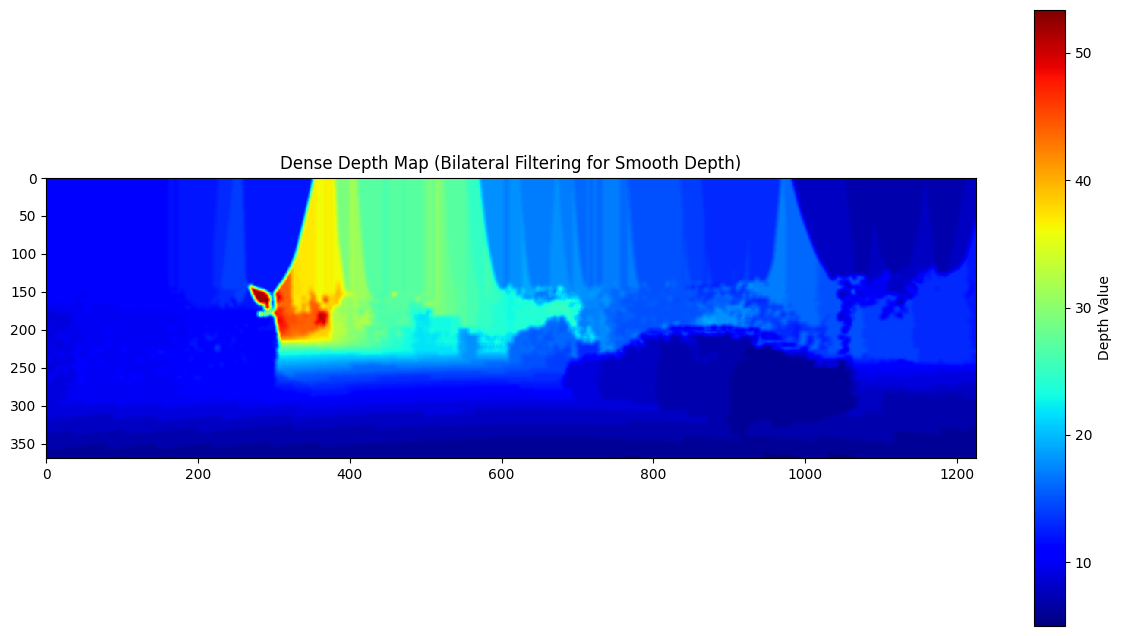

In [81]:
dense_depth_map_bilateral = cv2.bilateralFilter(dense_depth_map.astype(np.float32), d=9, sigmaColor=75, sigmaSpace=75)

# Save the filtered ground truth
np.save("dense_lidar_ground_truth_bilateral.npy", dense_depth_map_bilateral)

# Visualize
plt.figure(figsize=(15, 8))
plt.imshow(dense_depth_map_bilateral, cmap='jet', interpolation='nearest')
plt.colorbar(label="Depth Value")
plt.title("Dense Depth Map (Bilateral Filtering for Smooth Depth)")
plt.show()

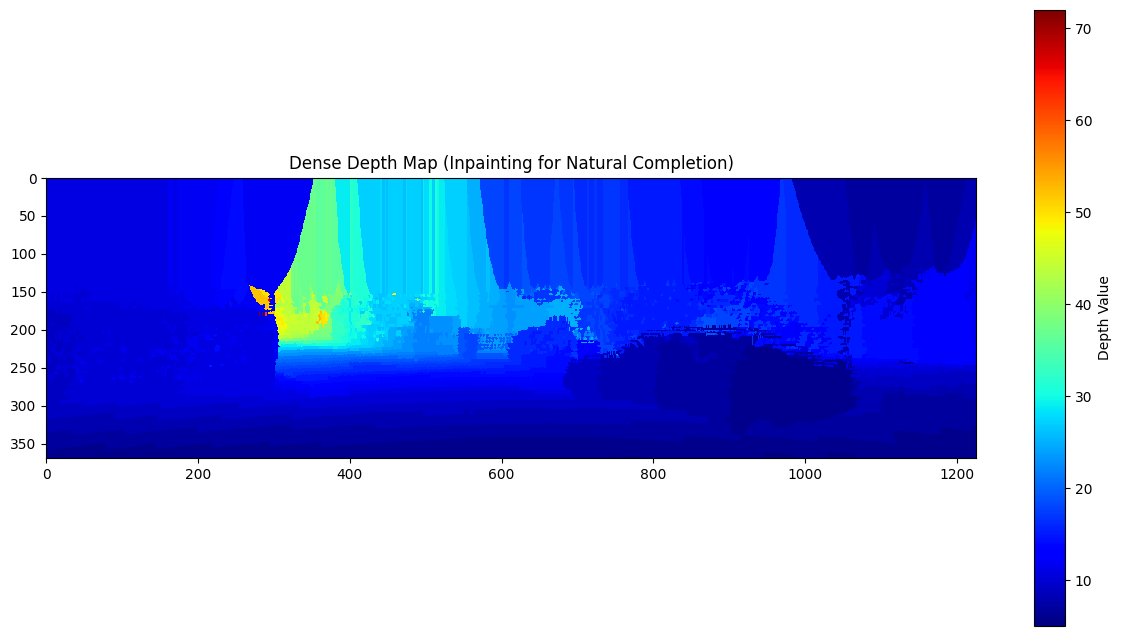

In [90]:
mask = (dense_depth_map == 0).astype(np.uint8)  # Create mask for missing values

# Apply inpainting to fill missing depth values
dense_depth_map_inpaint = cv2.inpaint(dense_depth_map.astype(np.float32), mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# Save the final dense depth map
np.save("dense_lidar_ground_truth_inpaint.npy", dense_depth_map_inpaint)

# Visualize
plt.figure(figsize=(15, 8))
plt.imshow(dense_depth_map_inpaint, cmap='jet', interpolation='nearest')
plt.colorbar(label="Depth Value")
plt.title("Dense Depth Map (Inpainting for Natural Completion)")
plt.savefig('OpenCV Inpaint')
plt.show()

In [76]:
depth_values

array([7., 7., 7., ..., 6., 6., 6.])

# View Result

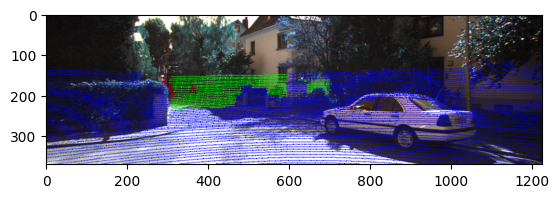

In [13]:
plt.imshow(image)

In [14]:
cv2.imwrite('correct_fused_image.png',image)

True

In [15]:
import numpy as np
import open3d as o3d

# Load point cloud from .bin file
def load_point_cloud(bin_path):
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)  # (x,y,z,intensity)
    return points[:, :3]

# Your point cloud path
bin_path = 'lidar_points.bin'
points = load_point_cloud(bin_path)

# Create Open3D point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Optionally colorize points based on height (Z-axis)
colors = np.zeros_like(points)
colors[:, 2] = (points[:, 2] - points[:, 2].min()) / np.ptp(points[:, 2])

pcd.colors = o3d.utility.Vector3dVector(colors)

# Visualize in 3D viewer
o3d.visualization.draw_geometries([pcd])


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Create dense map

In [95]:
def normalize(list1, min_bound, max_bound):
    '''Normalizes an input lists and returns  list with normalized values'''

    normalized_list = []
    min_value = min(list1)
    difference = max(list1) - min(list1)
    
    for x in list1:
        normalized_value = min_bound +  ((x - min_value) / difference) * (max_bound - min_bound)
        normalized_list.append(int(normalized_value))

    return normalized_list
    

In [123]:
depths = [c for (a,b,c) in filtered_lidar_points]
depths_normalized = normalize(depths,0,255)
filtered_lidar_points_np[i][0:2]

(146, 604)

In [125]:
depths_np = []
for i in range(len(filtered_lidar_points_np)):
    a , b = filtered_lidar_points_np[i][0:2]
    c = depths_normalized[i]
    depths_np.append((a,b,c))

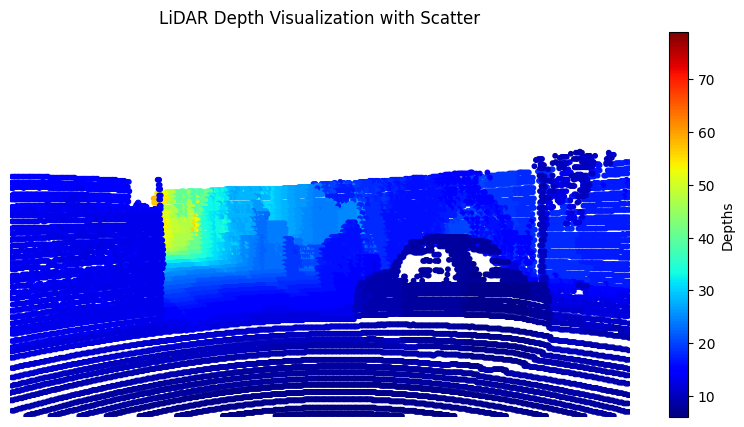

In [164]:
import numpy as np
import matplotlib.pyplot as plt

# Define image size (replace with actual image dimensions)

# Convert list to NumPy array
filtered_lidar_points_np = np.array(depths_np)

# Extract pixel coordinates (x, y) and depth values
x_coords = filtered_lidar_points_np[:, 0]
y_coords = filtered_lidar_points_np[:, 1]
depth_values = filtered_lidar_points_np[:, 2]

# Normalize depth values to range [0, 1] for colormap
min_depth, max_depth = np.min(depth_values), np.max(depth_values)
if max_depth > min_depth:
    normalized_depths =(0 + ((depth_values - min_depth) / (max_depth - min_depth)) * (255))
else:
    normalized_depths = np.zeros_like(depth_values)  # Avoid division by zero

# Create scatter plot on a black background
plt.figure(figsize=(10, 5))
plt.gca().set_facecolor('black')  # Set black background

# Plot LiDAR points using scatter (color-coded by depth)
plt.scatter(y_coords, x_coords, c=depths, cmap='jet', s=10, alpha=1.0)

# Adjust plot settings
plt.colorbar(label="Depths")
plt.title("LiDAR Depth Visualization with Scatter")
plt.xlim(0, width)   # Set x-axis limits
plt.ylim(height, 0)  # Flip y-axis to match image coordinates
plt.axis('off')      # Hide axes for a clean image
plt.savefig('Lidar.png')
plt.show()


# FoundationStereo

In [120]:
fs_depths = np.load('test_outputs/depth_meter.npy')

In [121]:
lidar_points_comparison_np = [(v,u,z) for (u,v,z) in lidar_points_comparison]

In [122]:
lidar_points_comparison[0], lidar_points_comparison_np[0]

((604, 146, 17.94), (146, 604, 17.94))

In [123]:
grid = np.zeros(shape=(370,1226),dtype=np.float32)

In [124]:
for x,y,z in lidar_points_comparison_np:
    grid[x,y] = z

In [125]:
differences = []
for i in range(370):
    for j in range(1226):
        if grid[i,j] != 0 :
            difference = abs(grid[i,j] - fs_depths[i,j])
            differences.append(difference)


In [126]:
np.mean(differences)

np.float32(4.984214)